In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.axis import Axis
from datetime import datetime, timedelta
from dataclasses import dataclass, field
from sklearn.linear_model import LinearRegression
import re

In [14]:
class Run:
    df: pd.DataFrame
    units = {}

    def __init__(self, df: pd.DataFrame):
        self.df = df

        for column in self.df.columns:
            setattr(self, column, self.df[column])

    @property
    def properties(self) -> list[str]:
        return list(self.df.columns)

    def plot(self, x: str | pd.Series, y: str | pd.Series, axis: Axis = None):
        if isinstance(x, str):
            x = self.df[x]
        if isinstance(y, str):
            y = self.df[y]

        # with plt.ioff():
        if axis:
            ax = axis
        else:
            fig, ax = plt.subplots()
            
        ret = []
        ax.plot(x, y)
        
        if y.name == 'v':
            max_idx = y.idxmax()
            front = y[:max_idx]
            diff = abs(front - front.iloc[0])
            min_idx = diff[diff < 0.01].index[-1]
    
            rectangle = patches.Rectangle((x[min_idx], y[min_idx]), x[max_idx] - x[min_idx], y[max_idx] - y[min_idx],
                                          linewidth=3, edgecolor='orange', facecolor='orange', alpha=0.2)
    
            # print(y[max_idx])
            # print(y[min_idx])    
            # print(y[min_idx-2:max_idx-1].to_numpy())
    
            x_space = x[min_idx - 2:max_idx - 1].to_numpy()
            y_space = y[min_idx - 2:max_idx - 1].to_numpy()
            # print(f"min: {y_space[0]}, max: {y_space[-1]}")
    
            w = (y_space[-1] - y_space[0]) / (x_space[-1] - x_space[0])
            b = y_space[0]
            ax.plot(x_space, w * (x_space - x_space[0]) + b, color='orange', linewidth=2)
            ax.text(0, 0, f'y = {w:.5f}x + {b}', color='orange', fontsize=10)
            ax.add_patch(rectangle)
            
            ret = [w, b]
        elif y.name == 'F':
            peak_idx = y[abs(y.iloc[0] - y) > 0.1].index[0]
            front = y[:peak_idx - 10]
            mean = front.mean()
            
            # ax.axvspan(x[y.index[0]], x[y.index[-1]], color='orange', alpha=0.2)
            # axvspan으로 0부터 y가 max가 되는 x까지
            ax.axvspan(x[y.index[0]], x[peak_idx], color='orange', alpha=0.2)
            ax.axhline(mean, color='orange', linewidth=2)
            ax.text(0, 0, f'y = {mean:.5f}', color='orange', fontsize=10)
            
            ret = [mean]
        
        ax.set_title(f'{y.name}-{x.name} graph')
        ax.set_xlabel(x.name + " " + self.units[x.name])
        ax.set_ylabel(y.name + " " + self.units[y.name])

        if not axis:
            plt.show()

        return ret


class Runs:
    def __init__(self, path: str = None, runs=None) -> None:
        if runs is not None:
            self.runs = runs
            return

        data = pd.read_csv(path)
        data = data[
            [c for c in data.columns if not (c.startswith('일시') or c.startswith('net') or c.startswith('acc'))]].dropna(
            axis=0, how='all')

        self.runs = {}
        for column in data.columns:
            matched = re.match(r'([a-zA-Zㄱ-힣, ]+) (\(.*\)) (?:Run|실행) (\d+)', column)

            if not matched:
                continue

            name = matched.group(1)
            unit = matched.group(2)
            run_id = int(matched.group(3))

            if run_id not in self.runs:
                self.runs[run_id] = pd.DataFrame(columns=['t', 'F', 'x', 'v', 'a'])

            ko_2_en = {
                '시간': 't',
                '힘': 'F',
                '위치': 'x',
                '속도': 'v',
                '가속도, 파랑': 'a'
            }
            
            self.runs[run_id][ko_2_en[name]] = data[column]
            Run.units[ko_2_en[name]] = unit

        for i in self.runs:
            self.runs[i] = Run(self.runs[i].dropna(axis=0, how='any'))

    def items(self):
        return self.runs.items()

    @property
    def indexes(self):
        return self.runs.keys()

    def __len__(self):
        return len(self.runs)

    def __getitem__(self, key: int | list):
        if isinstance(key, list) or isinstance(key, np.ndarray) or isinstance(key, tuple):
            return Runs(runs={k: self.runs[k] for k in key})
        elif isinstance(key, int):
            return self.runs[key]

    def analyze(self, massbar, weight) -> np.array:
        # with plt.ioff():
        # fig, ax = plt.subplots(1, len(self), figsize=(len(self) * 5, 3))
        
        fig, ax = plt.subplots(len(self), 1, figsize=(5, 5 * len(self)))
        # ret = pd.DataFrame(columns=['N', 'a'])
        ret = pd.DataFrame(columns=['a'])

        for i, run_id in enumerate(self.runs.keys()):
            run = self.runs[run_id]
            w, b = run.plot(x='t', y='v', axis=ax[i])
            # N, = run.plot(x='t', y='F', axis=ax[i, 1])
            ret.loc[run_id] = [w]

        plt.savefig(f"./imgs/mass{massbar}-{weight}.png")
        print(f"./imgs/mass{massbar}-{weight}.png saved")
        # plt.show()
        return ret


In [15]:
runs = Runs('./data/저장된 데이터.csv')

def get(runs, massbar=0, weight=0):
    map_list = [
        [(1, 2, 3),
         (4, 5, 6),
         (7, 8, 9),
         (11, 12, 14),
         (15, 16, 18)],
        [(19, 20, 21),
         (22, 23, 24),
         (25, 26, 27),
         (28, 29, 30),
         (31, 32, 33)],
        [(34, 35, 36),
         (37, 38, 39),
         (41, 42, 43),
         (44, 45, 46),
         (47, 48, 50)]
    ]
    
    return runs[map_list[massbar][weight // 10 - 1]]

./imgs/mass0-10.png saved
./imgs/mass0-20.png saved
./imgs/mass0-30.png saved
./imgs/mass0-40.png saved
./imgs/mass0-50.png saved
./imgs/mass1-10.png saved
./imgs/mass1-20.png saved
./imgs/mass1-30.png saved
./imgs/mass1-40.png saved
./imgs/mass1-50.png saved
./imgs/mass2-10.png saved
./imgs/mass2-20.png saved
./imgs/mass2-30.png saved
./imgs/mass2-40.png saved
./imgs/mass2-50.png saved


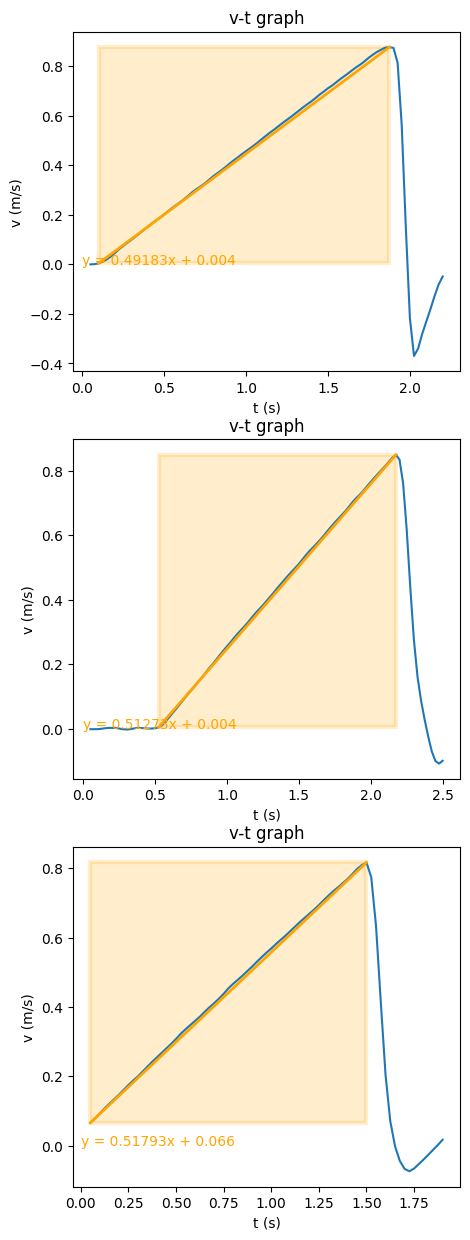

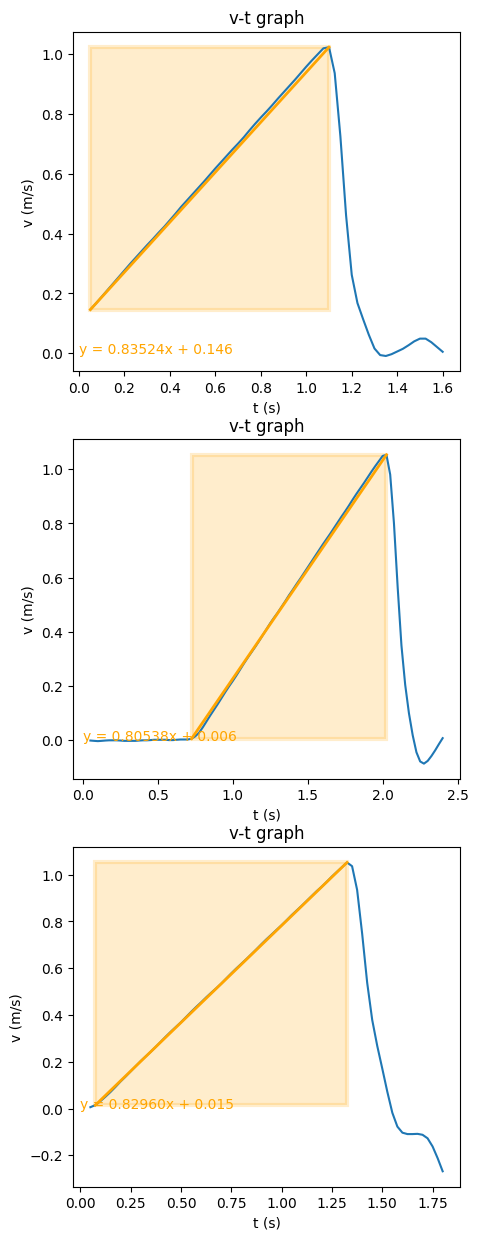

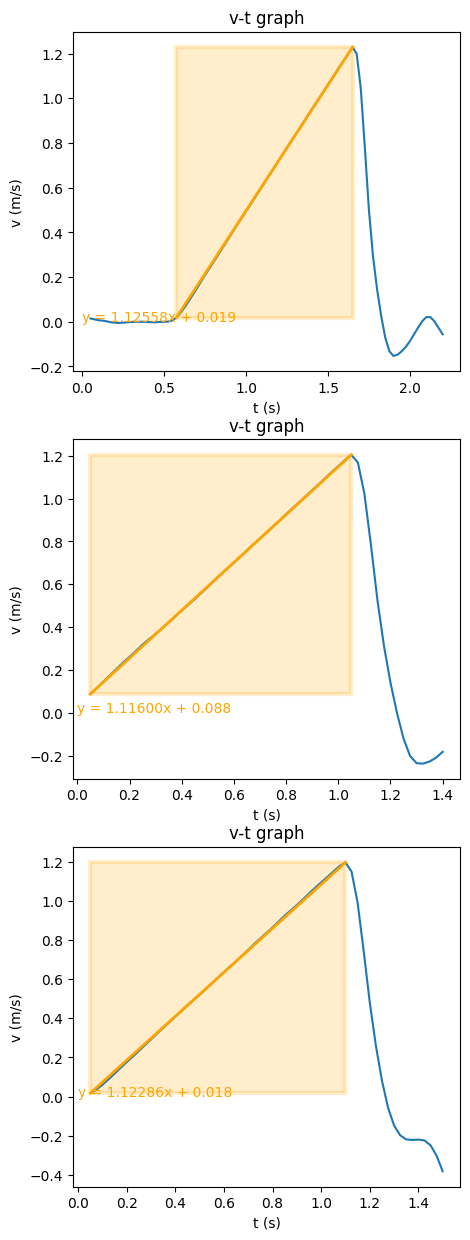

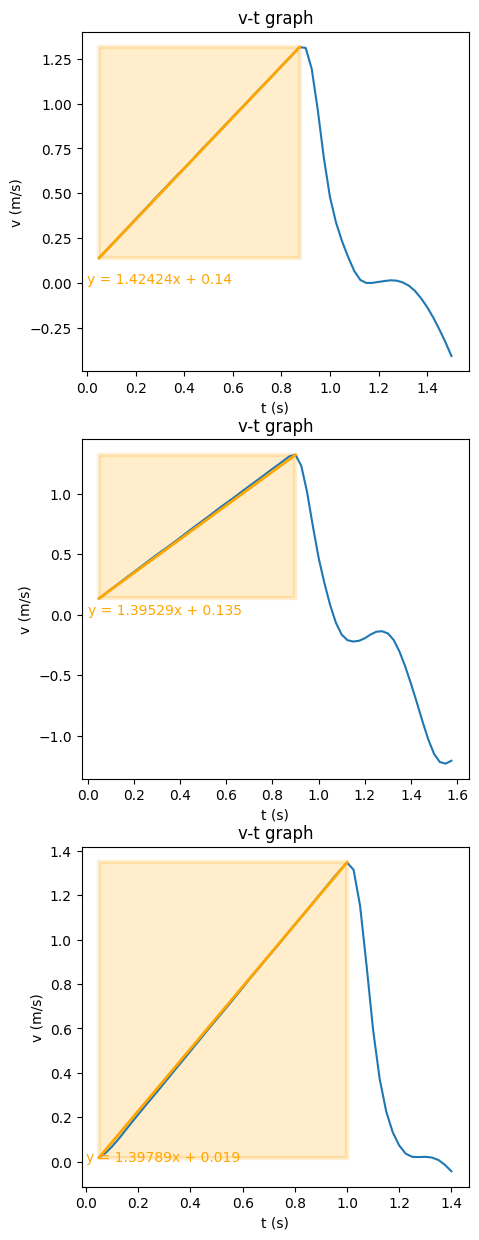

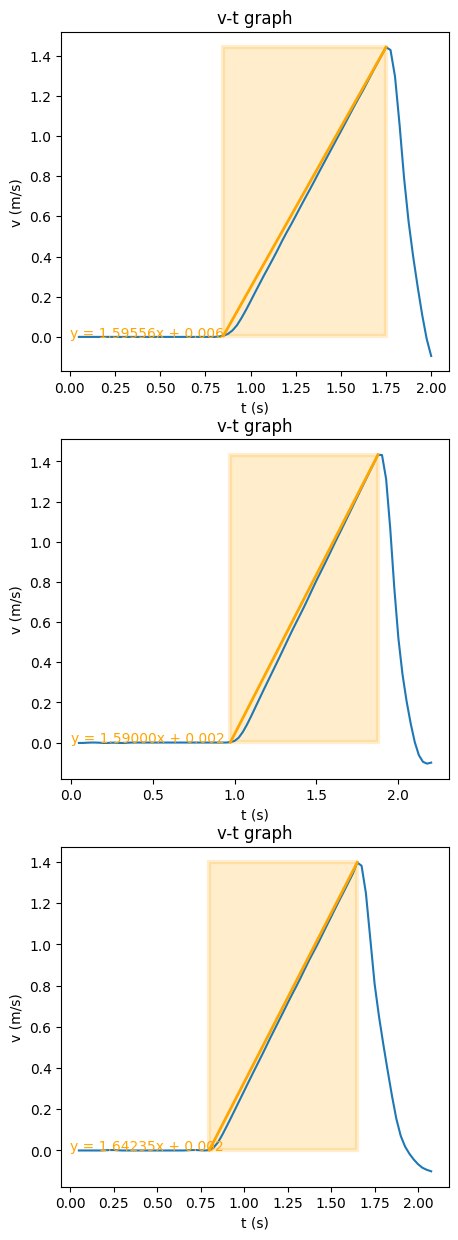

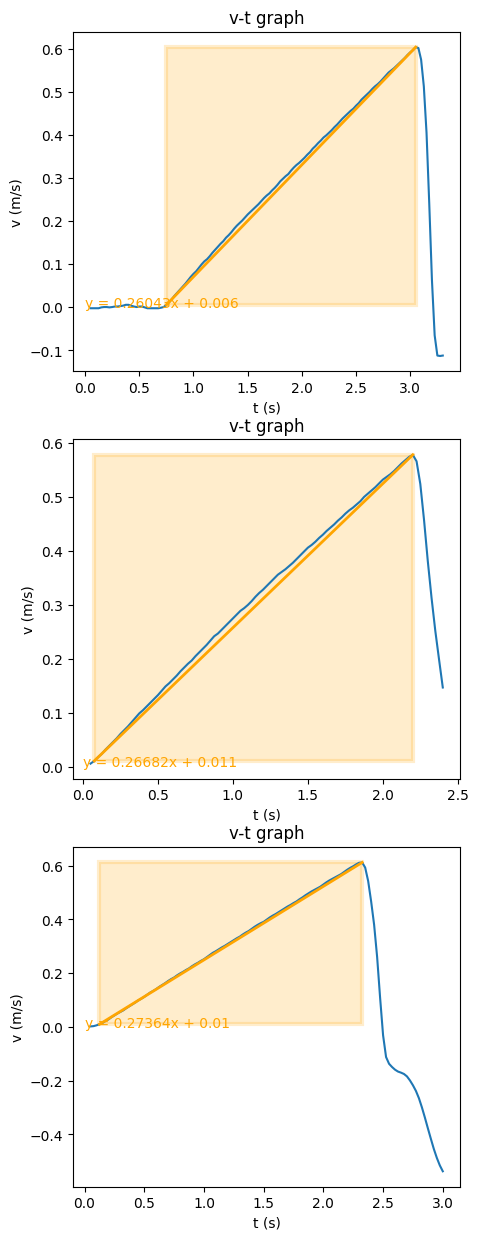

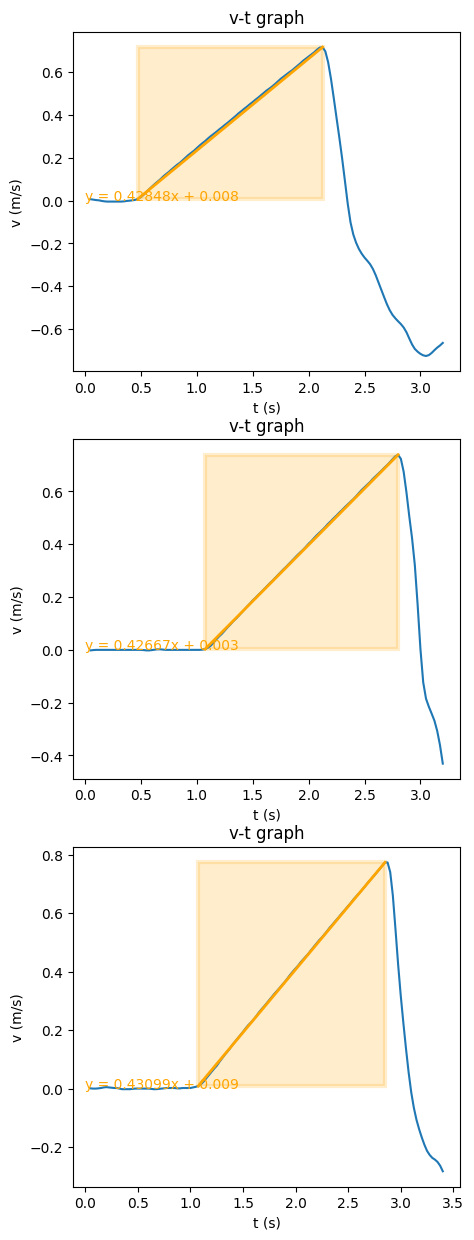

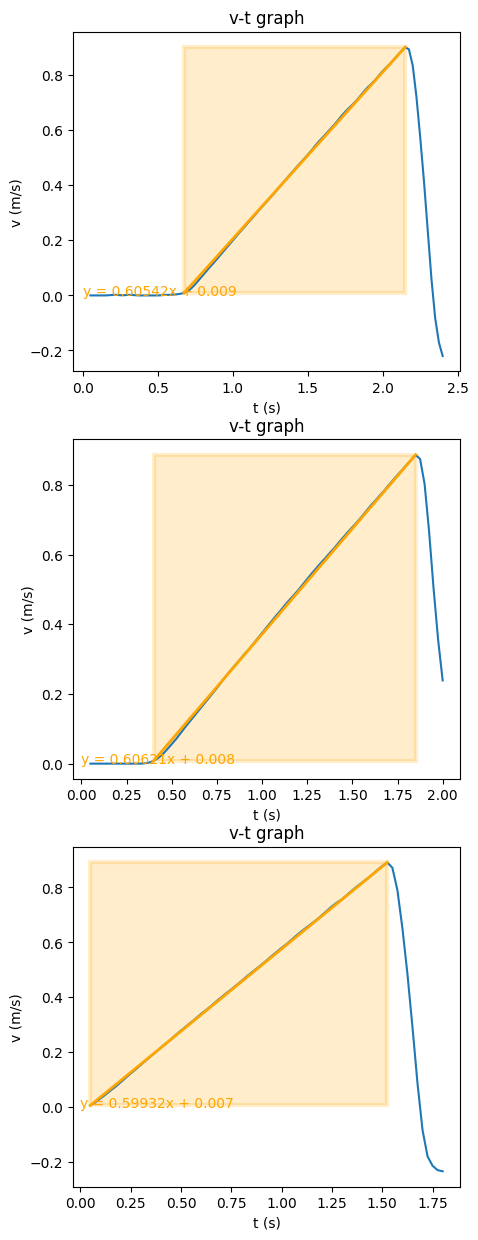

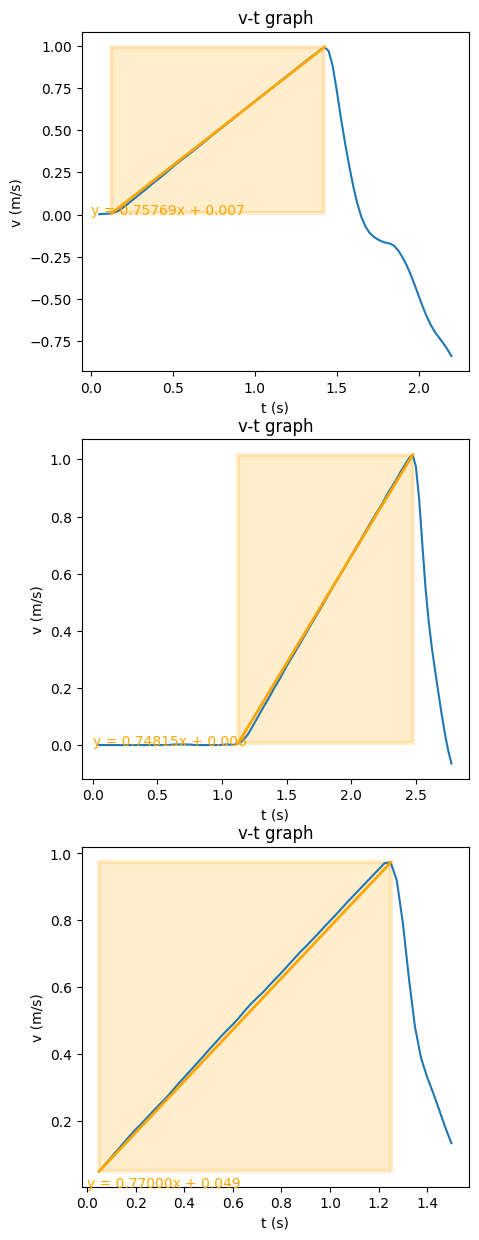

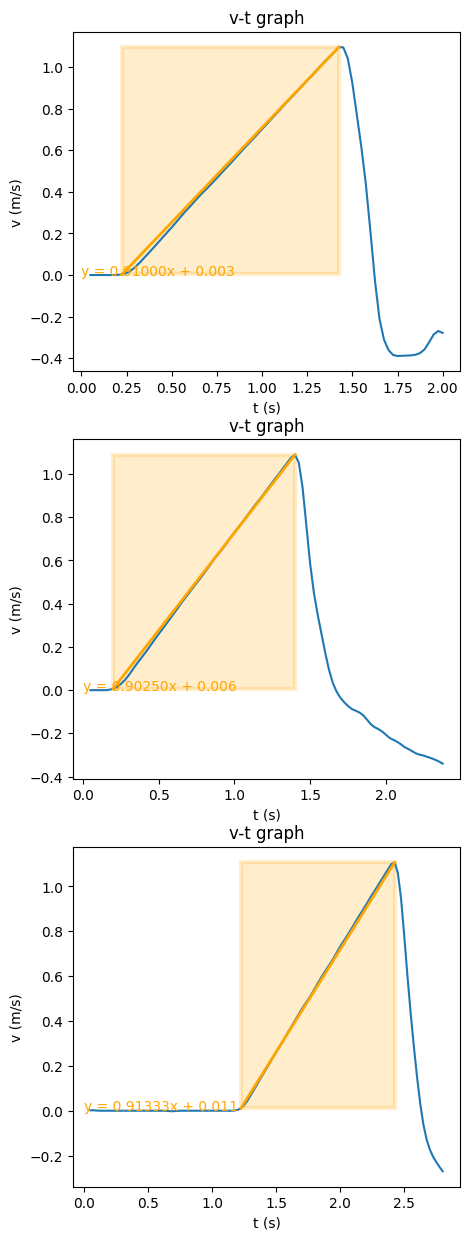

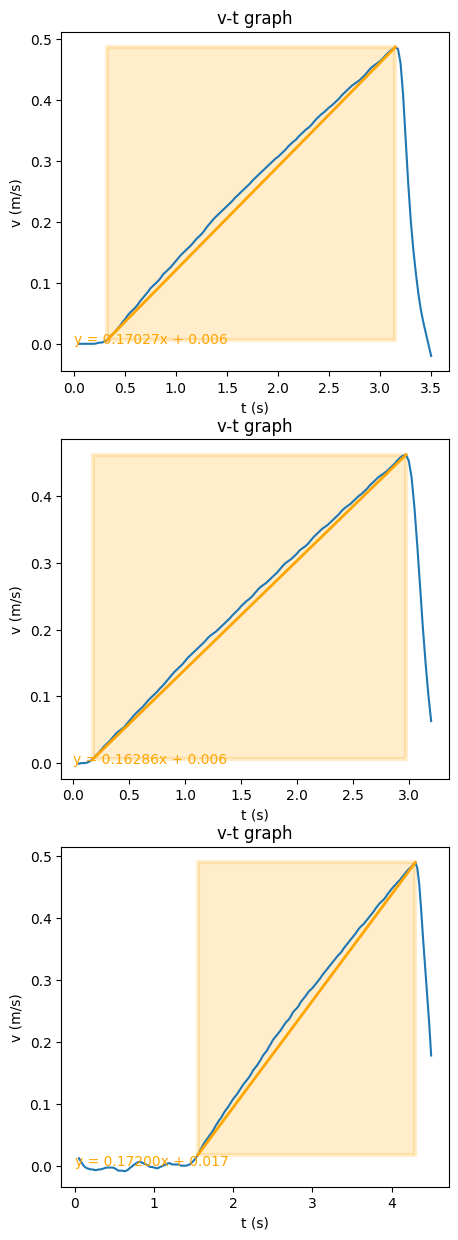

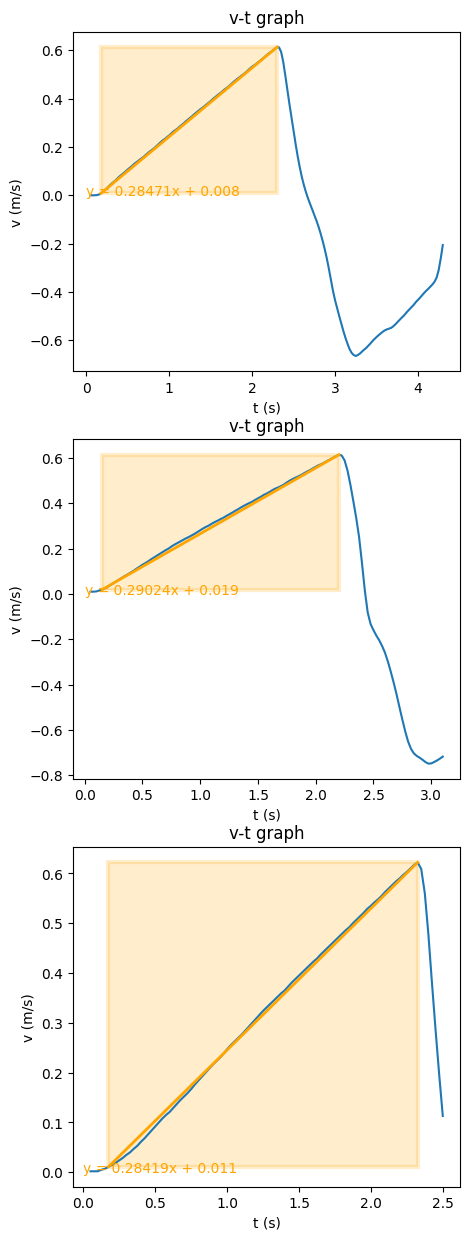

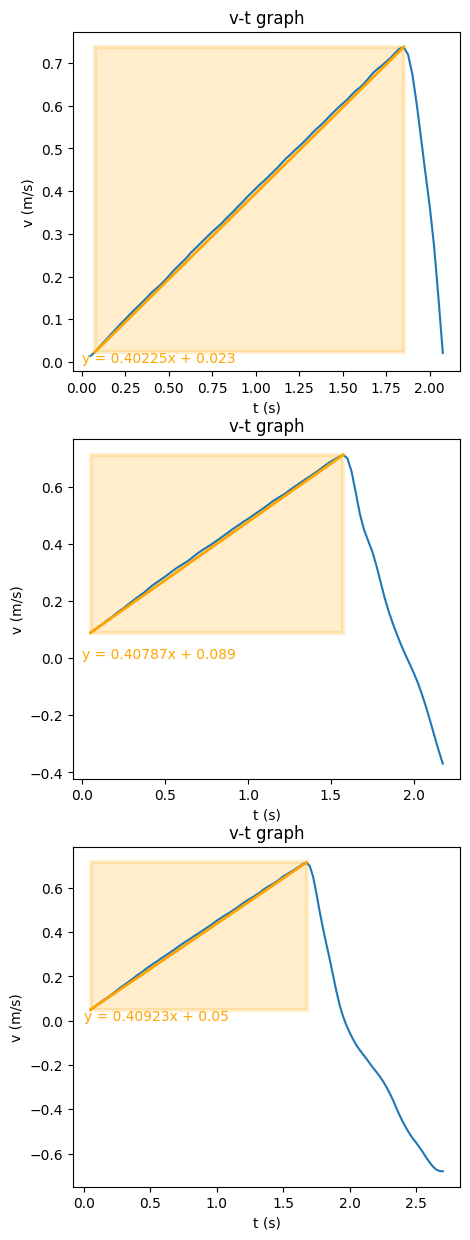

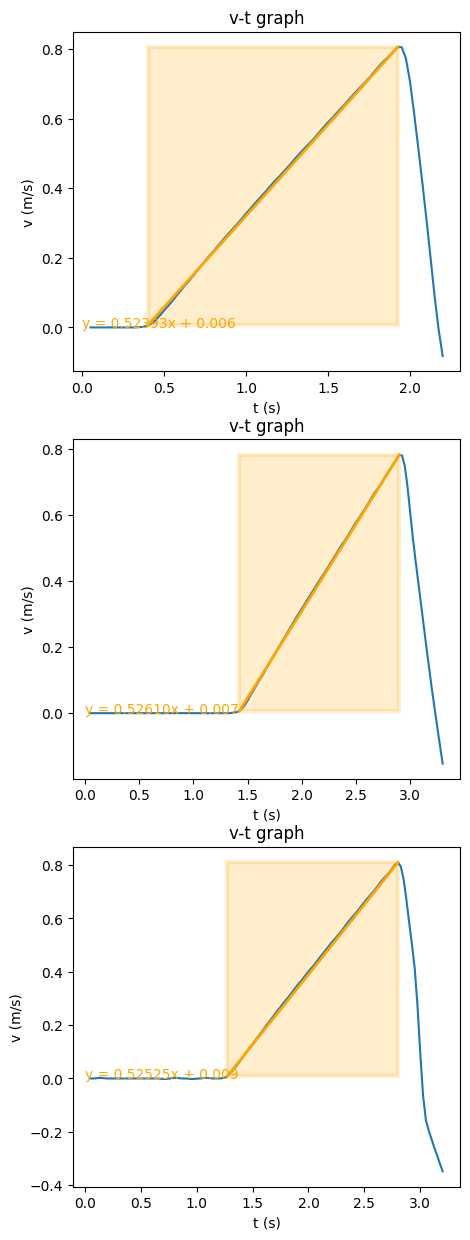

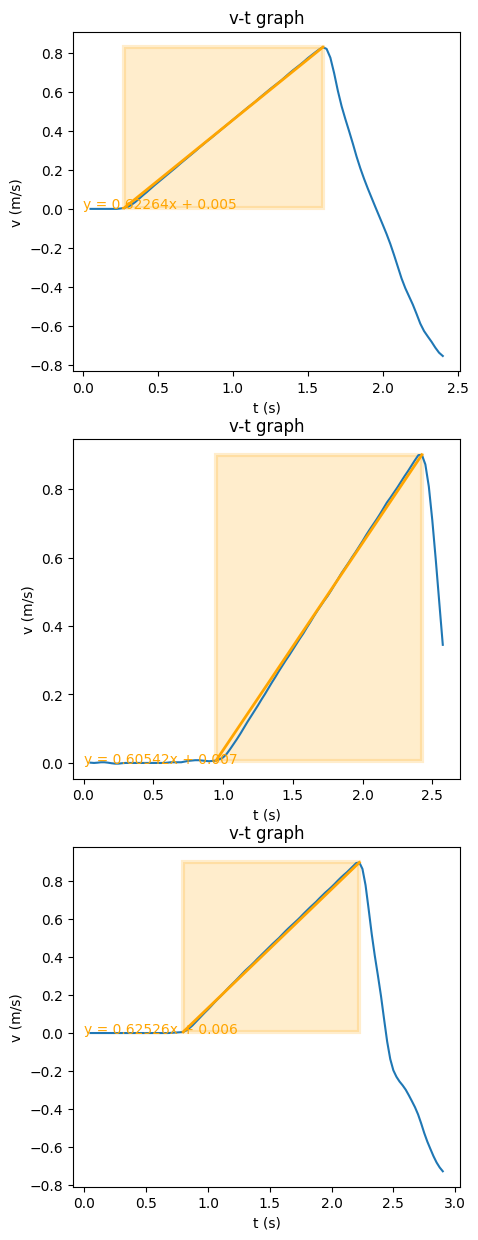

In [16]:
plot = get(runs, massbar=2, weight=30)

ret = pd.DataFrame(columns=['N', 'a'])
for i in range(3):
    for j in range(10, 60, 10):
        tmp = get(runs, massbar=i, weight=j).analyze(massbar=i, weight=j)
        ret = pd.concat([ret, tmp])

In [17]:
ret.to_excel("./data/result.xlsx")

ret

,N,a
1,NaN,0.491831
2,NaN,0.512727
3,NaN,0.517931
4,NaN,0.835238
5,NaN,0.805385
6,NaN,0.829600
7,NaN,1.125581
8,NaN,1.116000
9,NaN,1.122857
11,NaN,1.424242


In [18]:
import numpy as np
from sympy import *
from sympy.abc import *

g = 9.80665
μ = 0.0403 / g
r = 0.051 / 2
I = 7.25214E-08

a = ((m + μ*M) / (m - M - I/r**2)) * g
T1 = M*(a + μ*g)
T2 = m*(a - g)

pprint(a)
pprint(T1)
pprint(T2)

9.80665⋅(0.00410945633830105⋅M + m)
───────────────────────────────────
   -M + m - 0.000149837603305785   
  ⎛9.80665⋅(0.00410945633830105⋅M + m)         ⎞
M⋅⎜─────────────────────────────────── + 0.0403⎟
  ⎝   -M + m - 0.000149837603305785            ⎠
  ⎛9.80665⋅(0.00410945633830105⋅M + m)          ⎞
m⋅⎜─────────────────────────────────── - 9.80665⎟
  ⎝   -M + m - 0.000149837603305785             ⎠


In [31]:
bar_masss = np.array((248.23, 252.84)) / 1000
weights = np.array((9.97, 9.95, 9.97, 20.2 - 9.97, 9.97)) / 1000
hook_mass = np.array(5.17) / 1000
cart_mass = np.array(251.01) / 1000

expected_a = pd.Series()
expected_T1 = pd.Series()
expected_T2 = pd.Series()

for i, run_id in enumerate(ret.index):
    massbar_count = i // 15
    weight_count = (i // 3) % 5 + 1

    M = cart_mass + sum(bar_masss[:massbar_count])
    m = hook_mass + sum(weights[:weight_count])

    a = ((m + μ*M) / (m - M - I/r**2)) * g
    T1 = M*(a + μ*g)
    T2 = m*(a - g)

    expected_a[run_id] = a
    expected_T1[run_id] = T1
    expected_T2[run_id] = T2

ret['expected_a'] = expected_a
ret['expected_T1'] = expected_T1
ret['expected_T2'] = expected_T2

ret

,N,a,expected_a,expected_T1,expected_T2
1,-0.379375,0.491831,-0.671928,-0.158545,-0.158646
2,-0.373165,0.512727,-0.671928,-0.158545,-0.158646
3,-0.375962,0.517931,-0.671928,-0.158545,-0.158646
4,-0.294444,0.835238,-1.133121,-0.274309,-0.274479
5,-0.280685,0.805385,-1.133121,-0.274309,-0.274479
6,-0.289348,0.829600,-1.133121,-0.274309,-0.274479
7,-0.197414,1.125581,-1.637840,-0.400998,-0.401244
8,-0.224118,1.116000,-1.637840,-0.400998,-0.401244
9,-0.220278,1.122857,-1.637840,-0.400998,-0.401244
11,-0.147857,1.424242,-2.206534,-0.543747,-0.544077
